In [1]:
#include <iostream>
#include <string>
#include <stdio.h>

In [2]:
TFile *file = TFile::Open("Data_8TeV.root"); 

In [3]:
TTree *tree = (TTree*) file->Get("mini");
tree->Print()

******************************************************************************
*Tree    :mini      : 4-vectors + variables required for scaling factors     *
*Entries : 14945674 : Total =      3737586466 bytes  File  Size = 1366006484 *
*        :          : Tree compression factor =   2.74                       *
******************************************************************************
*Br    0 :runNumber : runNumber/I                                            *
*Entries : 14945674 : Total  Size=   59789737 bytes  File Size  =     297928 *
*Baskets :       70 : Basket Size=    1224192 bytes  Compression= 200.68     *
*............................................................................*
*Br    1 :eventNumber : eventNumber/I                                        *
*Entries : 14945674 : Total  Size=   59789885 bytes  File Size  =   44412272 *
*Baskets :       70 : Basket Size=    1224192 bytes  Compression=   1.35     *
*...................................................

activate variables

In [4]:
float evtw = -1;
Bool_t e_trig;
Bool_t mu_trig;
Bool_t good_vtx;
UInt_t lep_n;
UInt_t jet_n;
Float_t MET;
Float_t MET_phi;

Float_t lep_pt[10];  
Float_t lep_eta[10];  
Float_t lep_phi[10];  
Float_t lep_E[10];  
Int_t lep_type[10];  
Float_t lep_ptcone30[10];
Float_t lep_etcone20[10];

Float_t jet_pt[10];
Float_t jet_eta[10];
Float_t jet_jvf[10];
Float_t jet_MV1[10];


tree->SetBranchAddress("trigE", &e_trig);
tree->SetBranchAddress("trigM", &mu_trig);
tree->SetBranchAddress("hasGoodVertex", &good_vtx);
tree->SetBranchAddress("lep_n", &lep_n);
tree->SetBranchAddress("jet_n", &jet_n);
tree->SetBranchAddress("jet_eta", &jet_eta);
tree->SetBranchAddress("met_et", &MET);
tree->SetBranchAddress("met_phi", &MET_phi);

tree->SetBranchAddress("lep_pt", &lep_pt);
tree->SetBranchAddress("lep_eta", &lep_eta);
tree->SetBranchAddress("lep_phi", &lep_phi);
tree->SetBranchAddress("lep_E", &lep_E);
tree->SetBranchAddress("lep_type", &lep_type);
tree->SetBranchAddress("lep_ptcone30", &lep_ptcone30);
tree->SetBranchAddress("lep_etcone20", &lep_etcone20);

tree->SetBranchAddress("jet_pt", &jet_pt);

tree->SetBranchAddress("jet_jvf", &jet_jvf);
tree->SetBranchAddress("jet_MV1", &jet_MV1);



In [5]:
TCanvas *canvas = new TCanvas("Canvas","",800,600);

In [6]:
TH1F *cutflow = new TH1F("Cutflow","Cutflow; Cut; Events",10,0,10);
TH1F *hist_njets = new TH1F("Number of jets","n-jets; Jet multiplicity; Events",10,0,10);

In [7]:
//histograms before cuts
TH1F *hist_lep_pt_b = new TH1F("Lep Pt no cuts","Lep pT; pT(GeV);Events",20,1000,1000000);
TH1F *hist_lep_ptcone30_b = new TH1F("Leptons_ptcone30 no cuts","Lepton ptcone30; Lep_ptcone30; Events",20,0,1);
TH1F *hist_lep_etcone20_b = new TH1F("Leptons_etcone20 no cuts","Lepton etcone20; Lep_etcone20; Events",20,-1,1);
TH1F *hist_lep_eta_b = new TH1F("Leptons_eta no cuts","Lepton eta; Lep_eta; Events",20,-4,4);
TH1F *hist_jets_pt_b = new TH1F("Jets_pt no cuts","Jets pt; Jets_pt; Events",20,0,1000000);
TH1F *hist_jets_eta_b = new TH1F("Jets_eta no cuts","Jets_eta; Jets_eta; Events",20,-4,4);
TH1F *hist_jets_JVF_b = new TH1F("Jets_JVF no cuts","Jets_JVF; Jets JVF; Events",50,0,1);
TH1F *hist_jets_MV1_b = new TH1F("Jets_MV1 no cuts","Jets_MV1; Jets MV1; Events",10,0,1);
TH1F *hist_bjets_n_b = new TH1F("b-jets_n no cuts","b-jets_number;b-jets number; Events",200,0,10);
TH1F *hist_MET_b = new TH1F("MET no cuts","MET; MET; Events",200,0,100000);
TH1F *hist_MTW_b = new TH1F("MTW no cuts","MTW; MTW; Events",200,0,100000);

//histograms after cuts
TH1F *hist_lep_pt = new TH1F("Lep Pt","Lep pT; pT(GeV);Events",20,1000,1000000);
TH1F *hist_lep_ptcone30 = new TH1F("Leptons_ptcone30","Lepton ptcone30; Lep_ptcone30; Events",20,0,1);
TH1F *hist_lep_etcone20 = new TH1F("Leptons_etcone20","Lepton etcone20; Lep_etcone20; Events",20,-1,1);
TH1F *hist_lep_eta = new TH1F("Leptons_eta","Lepton eta; Lep_eta; Events",20,-4,4);
TH1F *hist_jets_pt = new TH1F("Jets_pt","Jets pt; Jets_pt; Events",20,0,1000000);
TH1F *hist_jets_eta = new TH1F("Jets_eta","Jets_eta; Jets_eta; Events",20,-4,4);
TH1F *hist_jets_JVF = new TH1F("Jets_JVF","Jets_JVF; Jets JVF; Events",50,0,1);
TH1F *hist_jets_MV1 = new TH1F("Jets_MV1","Jets_MV1; Jets MV1; Events",10,0,1);
TH1F *hist_bjets_n = new TH1F("b-jets_n","b-jets_number;b-jets number; Events",200,0,10);
TH1F *hist_MET = new TH1F("MET","MET; MET; Events",200,0,100000);
TH1F *hist_MTW = new TH1F("MTW","MTW; MTW; Events",200,0,100000);

In [8]:
int nentries, nbytes, i;
nentries = (Int_t)tree->GetEntries();

int cut1 = 0;
int cut2 = 0;
int cut3 = 0;
int cut4 = 0;
int cut5 = 0;
int cut6 = 0;
int cut7 = 0;
int cut8 = 0;
int good_lep = 0;


for (i = 0; i < nentries; i++)
{
    nbytes = tree->GetEntry(i);   

    //First cut: Good vertex
    if(!good_vtx) continue;
    cut1++;
    cutflow->Fill(1);

    //Second cut: Trigger
    if(!e_trig && !mu_trig) continue;
    cut2++;
    cutflow->Fill(2);
        
    // Preselection of good leptons                                                                                
    int n_mu=0;
    int n_el=0;
    int n_lep=0;

    //Loop over leptons
    for(unsigned int i=0; i<lep_n; i++){
        hist_lep_pt_b->Fill(lep_pt[i]);
        hist_lep_ptcone30_b->Fill(lep_ptcone30[i]/lep_pt[i]);
        hist_lep_etcone20_b->Fill(lep_etcone20[i]/lep_pt[i]);
        hist_lep_eta_b->Fill(lep_eta[i]);
        if( lep_pt[i] < 25000.) continue; 
        if( lep_ptcone30[i]/lep_pt[i] > 0.15 ) continue; 
        if( lep_etcone20[i]/lep_pt[i] > 0.15 ) continue;  
        if( lep_type [i]==13 && TMath::Abs(lep_eta[i]) < 2.5 ){
            n_mu++;
            good_lep=i;}
        if( lep_type [i]==11 && TMath::Abs(lep_eta[i]) < 2.47 ){
            if(TMath::Abs(lep_eta[i])<1.37 || TMath::Abs(lep_eta[i])>1.52){
                n_el++;
                good_lep=i;}
        }
        hist_lep_pt->Fill(lep_pt[i]);
        hist_lep_ptcone30->Fill(lep_ptcone30[i]/lep_pt[i]);
        hist_lep_etcone20->Fill(lep_etcone20[i]/lep_pt[i]);
        hist_lep_eta->Fill(lep_eta[i]);
        }
    n_lep=n_mu+n_el;
     //Select events with only 1 good lepton and fill the cutflow histogram 
    //Example:
    //Third cut (one good lepton):
    
    //fill the histogram of lep pt
 
    
    if(n_lep!=1) continue;
    cutflow->Fill(3); 
    cut3++;
    
  
    
    int n_jets=0;
    int n_bjets=0;
    
    //Number of jets distribution
    hist_njets->Fill(jet_n,evtw);

    //Fourth cut: At least 4 jets
    if(jet_n<4) continue; 
    cutflow->Fill(4); 
    cut4++;

    for(unsigned int j=0; j<jet_n; j++){
        hist_jets_pt_b->Fill(jet_pt[j]);
        hist_jets_eta_b->Fill(jet_eta[j]);
        hist_jets_JVF_b->Fill(jet_jvf[j]);
        hist_jets_MV1_b->Fill(jet_MV1[j]);
        // To complete: apply jet cuts to find the good jets
        if(jet_pt[j]<25000.) continue;
        //Eta cut
        if(jet_eta[j]>2.5 ) continue;
        // JVF cleaning
        if(TMath::Abs(jet_eta[j])<2.4 && jet_pt[j]<50000. && jet_jvf[j]<0.5) continue;
        n_jets++;
        // cut on 0.7892 MV1 and count the number of b-jets
        if(jet_MV1[j]<0.7892) continue;
        n_bjets++;
        hist_jets_pt->Fill(jet_pt[j]);
        hist_jets_eta->Fill(jet_eta[j]);
        hist_jets_JVF->Fill(jet_jvf[j]);
        hist_jets_MV1->Fill(jet_MV1[j]);
        }
    
    //Fifth cut: At least 4 good jets
    if(n_jets<4) continue; 
    cutflow->Fill(5); 
    cut5++;
    
    hist_bjets_n_b->Fill(n_bjets);
    //Sixth cut: at least one b-jet
    if(n_bjets<2) continue;
    cutflow->Fill(6); 
    cut6++;
    hist_bjets_n->Fill(n_bjets);
    
    hist_MET_b->Fill(MET);
    //Seventh cut: MET > 30 GeV
    if(MET<30000.) continue;
    cutflow->Fill(7);
    cut7++;
    hist_MET->Fill(MET);
    
    // TLorentzVector definitions                                                               
    TLorentzVector Lepton  = TLorentzVector();
    TLorentzVector  MeT  = TLorentzVector();

    //To complete: Lorentz vectors for the lepton and MET. Use SetPtEtaPhiE().
    
    Lepton.SetPtEtaPhiE(lep_pt[good_lep],lep_eta[good_lep],lep_phi[good_lep],lep_E[good_lep]);
    MeT.SetPtEtaPhiE(MET,0,MET_phi,MET);
    //Calculation of the mTW using TLorentz vectors             
    float mTW = sqrt(2*Lepton.Pt()*MeT.Et()*(1-cos(Lepton.DeltaPhi(MeT))));

    hist_MTW_b->Fill(mTW);
    //Eight cut: mTW > 30 GeV
    if(mTW>30000.){
    cutflow->Fill(8);
    cut8++;
    hist_MTW->Fill(mTW);
    }
}

std::cout << "Done!" << std::endl;
std::cout << "All events:" << nentries << std::endl;
std::cout << "Cut1:" << cut1 << std::endl;
std::cout << "Cut2:" << cut2 << std::endl;
std::cout << "Cut3:" << cut3 << std::endl;
std::cout << "Cut4:" << cut4 << std::endl;
std::cout << "Cut5:" << cut5 << std::endl;
std::cout << "Cut6:" << cut6 << std::endl;
std::cout << "Cut7:" << cut7 << std::endl;
std::cout << "Cut8:" << cut8 << std::endl;

Done!
All events:14945674
Cut1:14656440
Cut2:14656440
Cut3:11533698
Cut4:61833
Cut5:61516
Cut6:10804
Cut7:8557
Cut8:7180


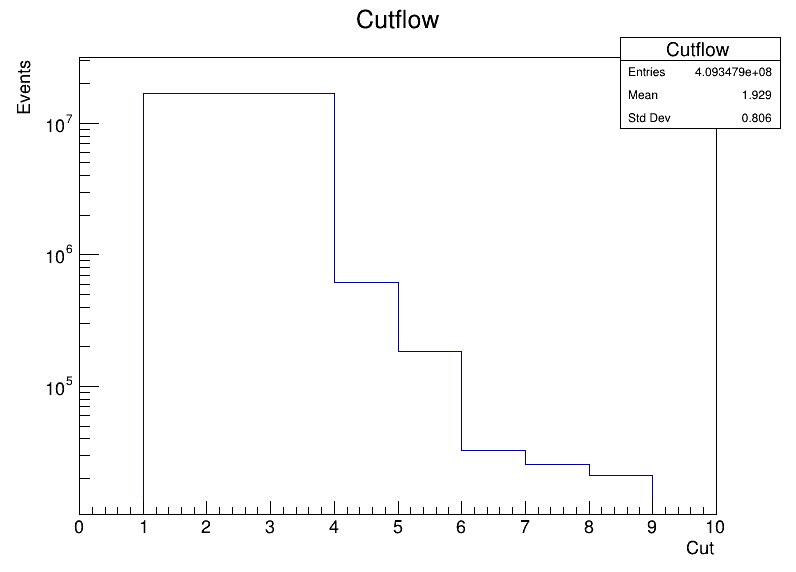

In [21]:
cutflow->Draw("");
canvas->SetLogy();
canvas->Draw();

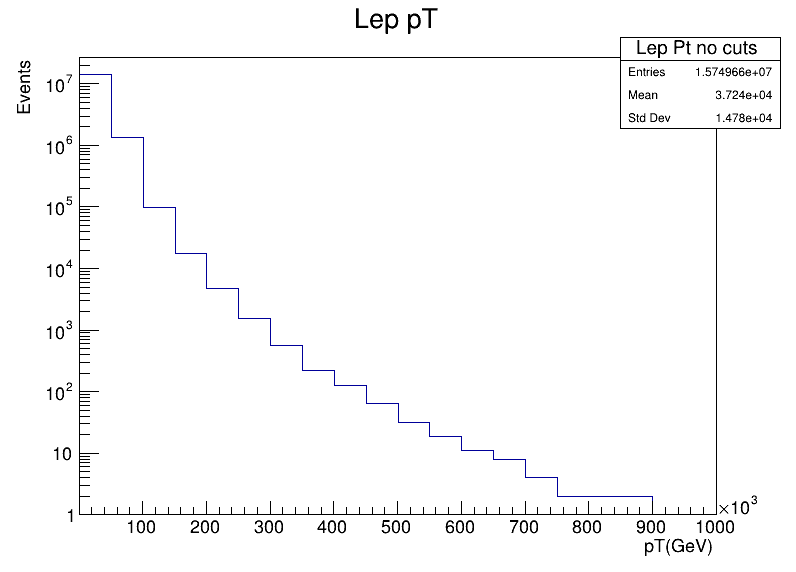

In [9]:
hist_lep_pt_b->Draw();
canvas->SetLogy();
canvas->Draw();

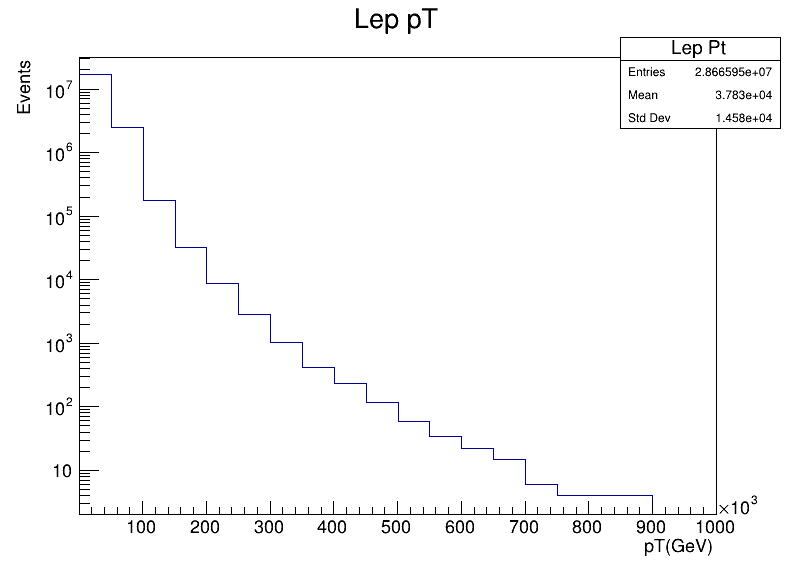

Warning in <TCanvas::Constructor>: Deleting canvas with same name: Canvas


In [34]:
TCanvas *canvas = new TCanvas("Canvas","",800,600);
hist_lep_pt->Draw();
canvas->SetLogy();
canvas->Draw();

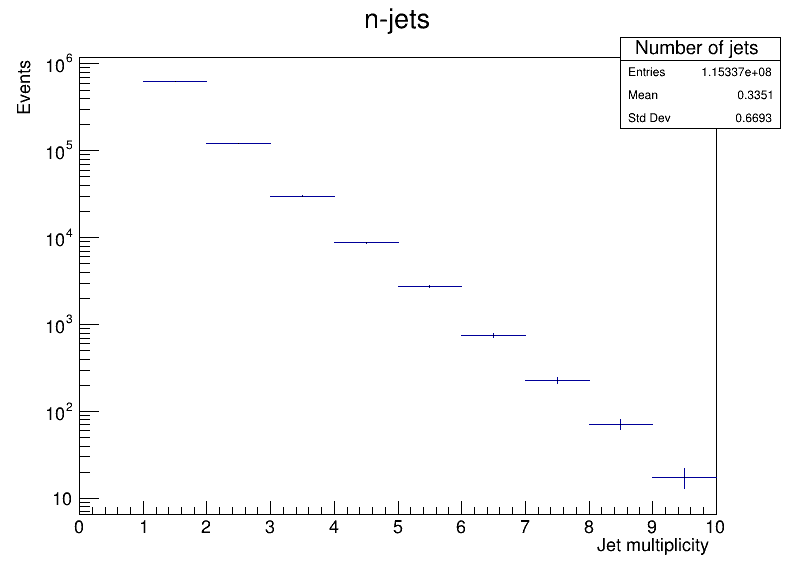

In [22]:
hist_njets->Draw();
canvas->Draw();

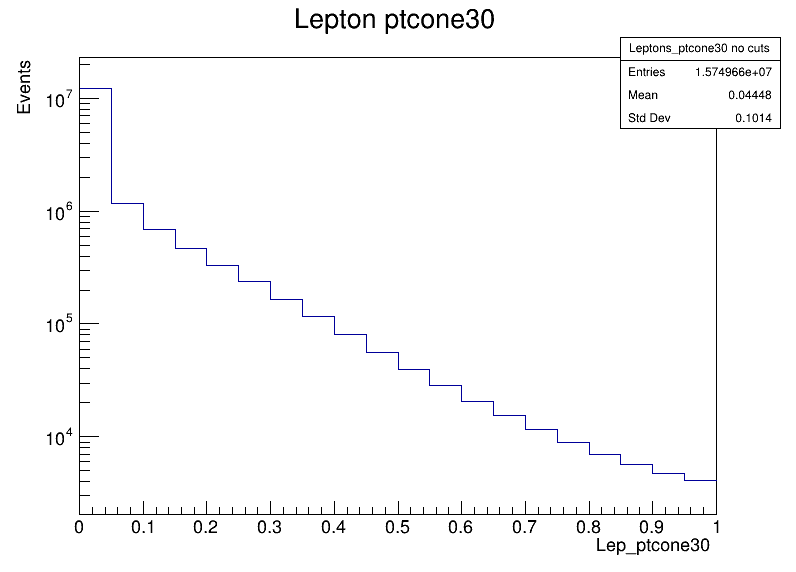

In [11]:
hist_lep_ptcone30_b->Draw();
canvas->SetLogy();
canvas->Draw();

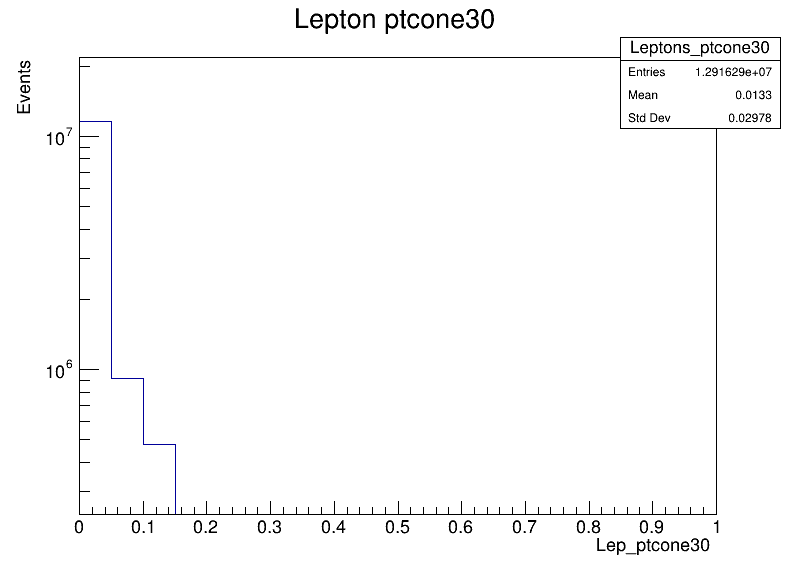

In [37]:
hist_lep_ptcone30->Draw();
canvas->SetLogy();
canvas->Draw();

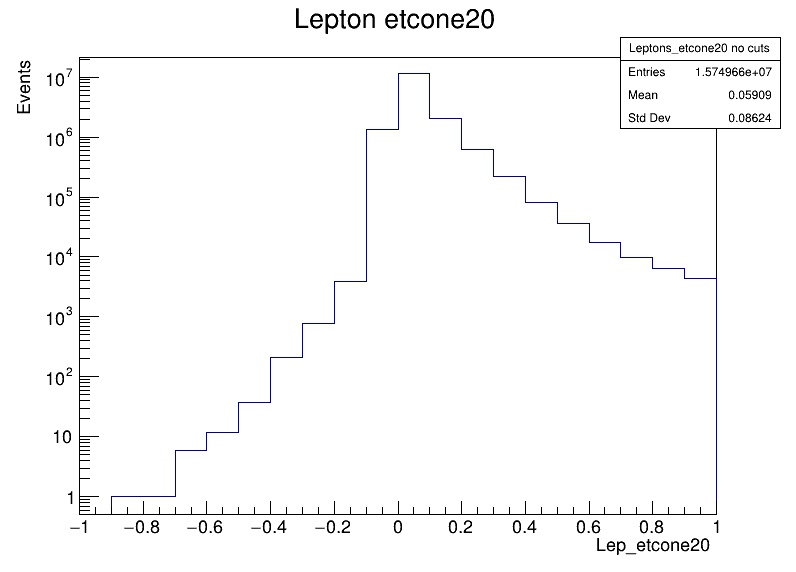

In [12]:
hist_lep_etcone20_b->Draw();
canvas->SetLogy();
canvas->Draw();

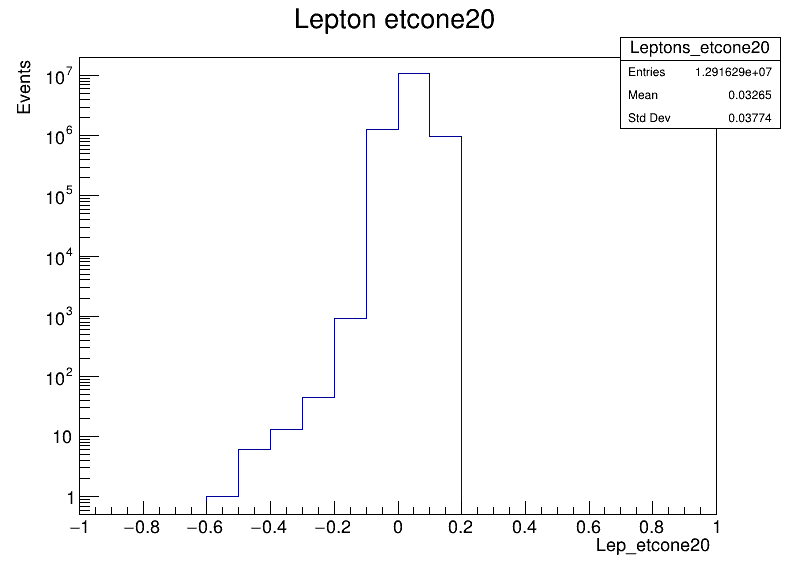

In [39]:
hist_lep_etcone20->Draw();
canvas->SetLogy();
canvas->Draw();

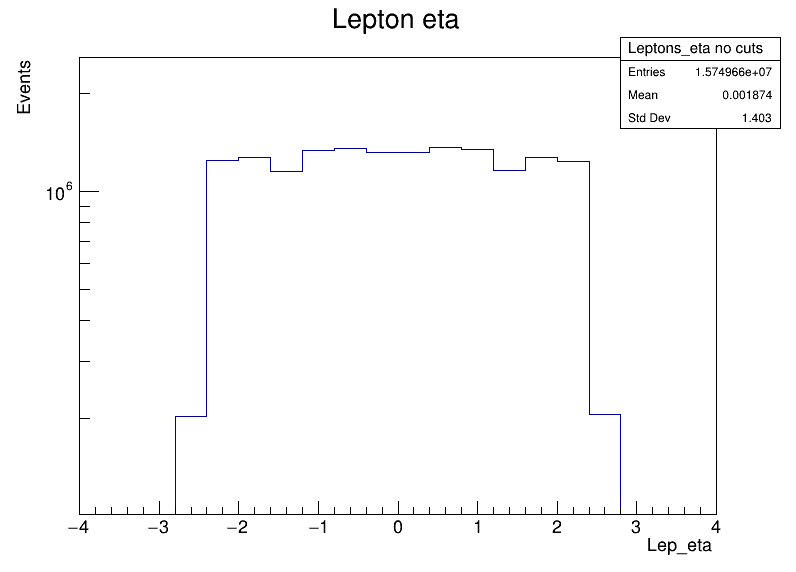

In [13]:
hist_lep_eta_b->Draw();
canvas->SetLogy();
canvas->Draw();

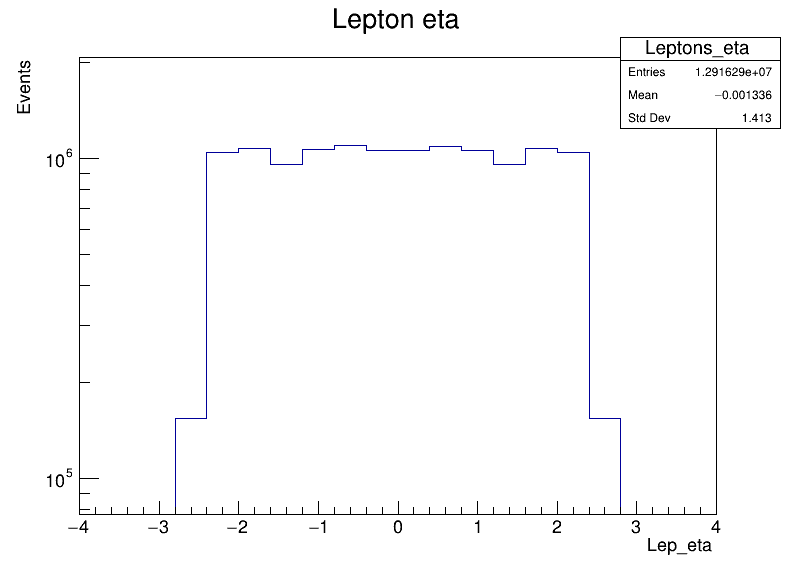

In [40]:
hist_lep_eta->Draw();
canvas->SetLogy();
canvas->Draw();

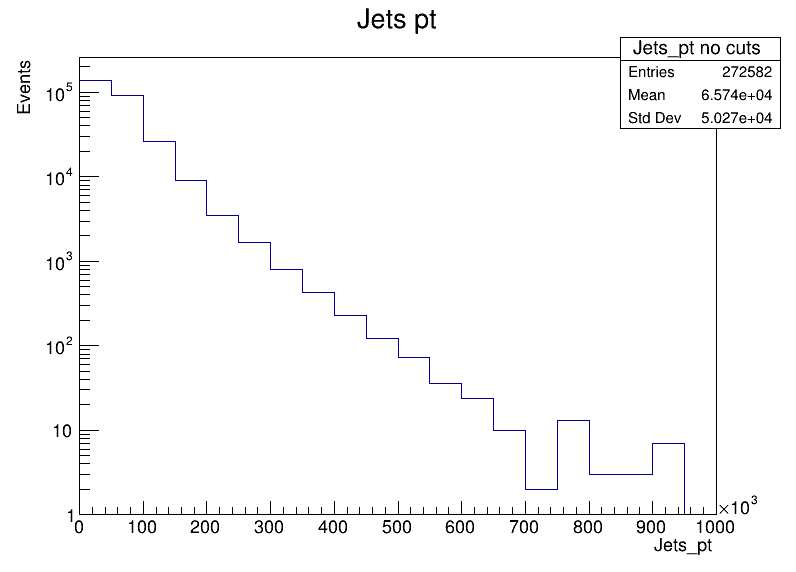

In [14]:
hist_jets_pt_b->Draw();
canvas->SetLogy();
canvas->Draw();

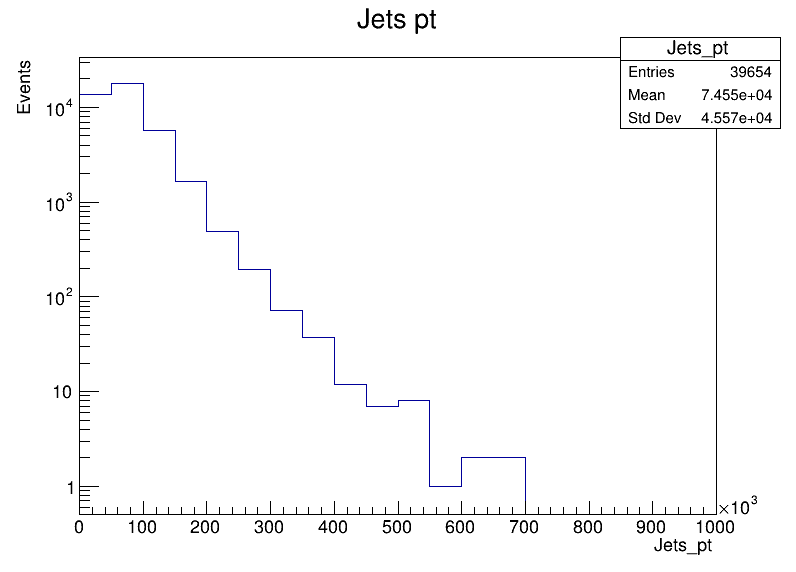

In [41]:
hist_jets_pt->Draw();
canvas->SetLogy();
canvas->Draw();

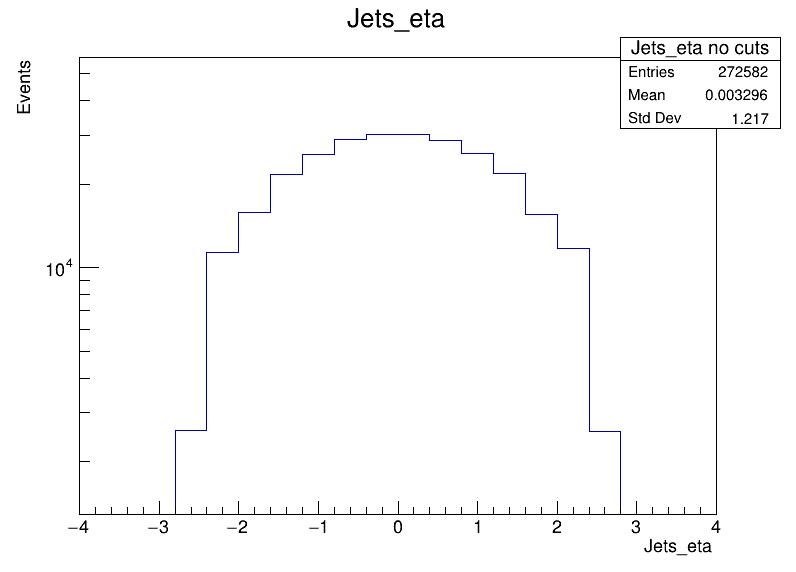

In [15]:
hist_jets_eta_b->Draw();
canvas->SetLogy();
canvas->Draw();

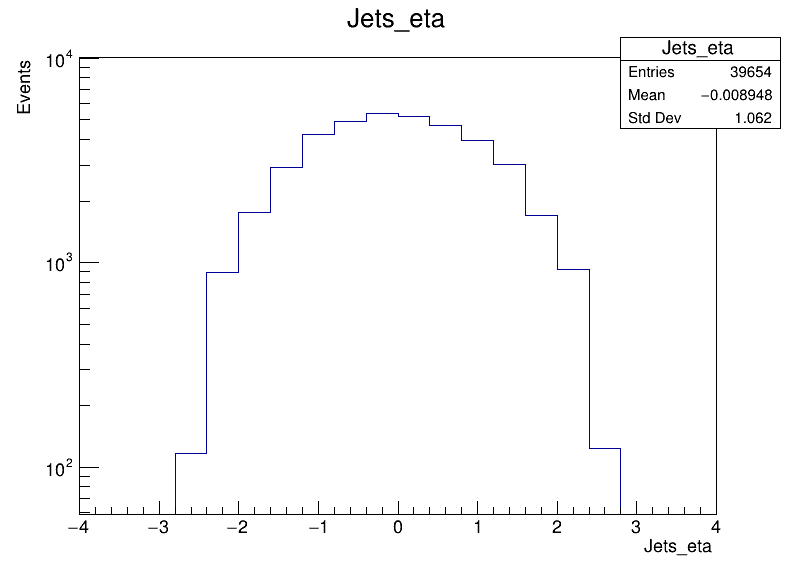

In [42]:
hist_jets_eta->Draw();
canvas->SetLogy();
canvas->Draw();

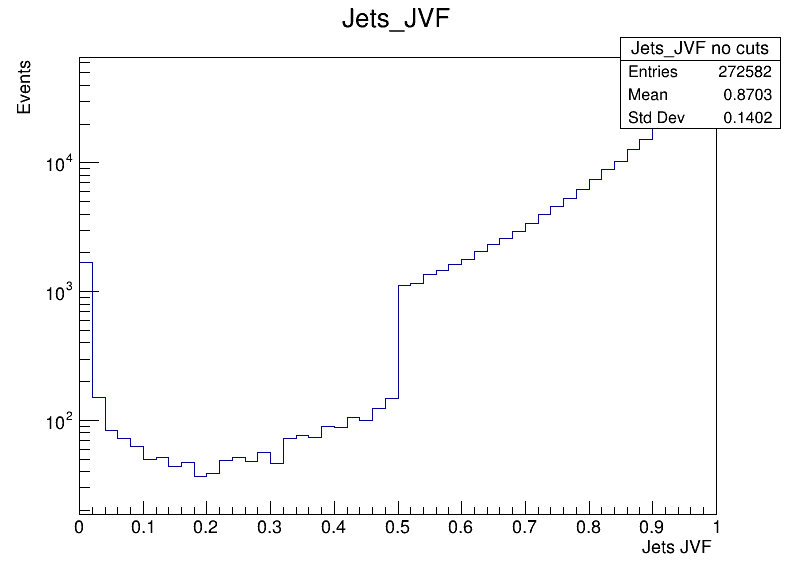

In [16]:
hist_jets_JVF_b->Draw();
canvas->SetLogy();
canvas->Draw();

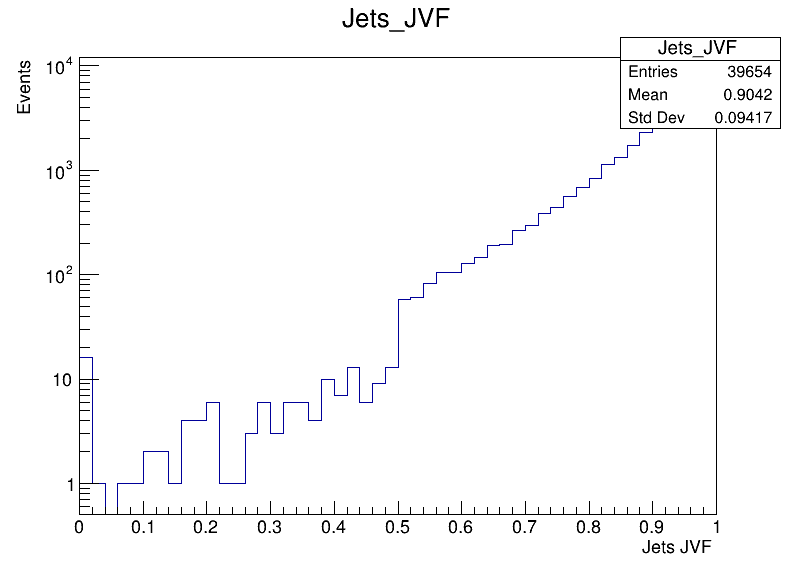

In [43]:
hist_jets_JVF->Draw();
canvas->SetLogy();
canvas->Draw();

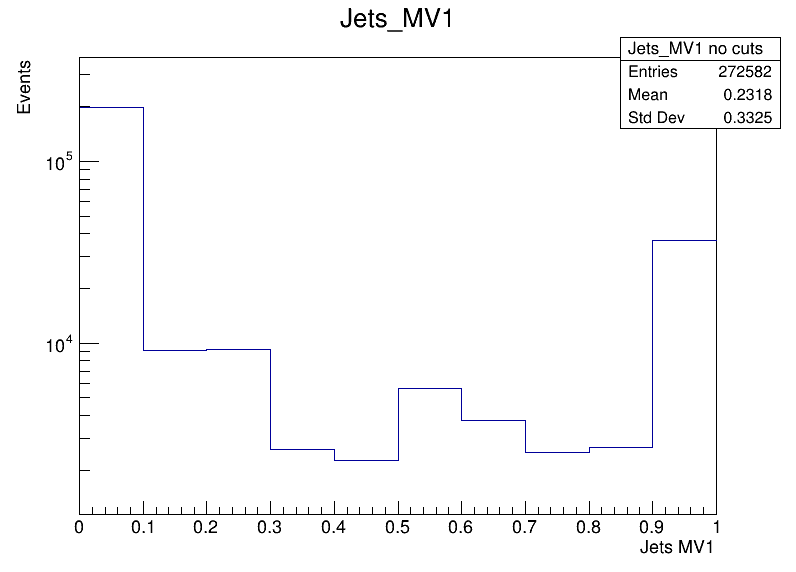

In [17]:
hist_jets_MV1_b->Draw();
canvas->SetLogy();
canvas->Draw();

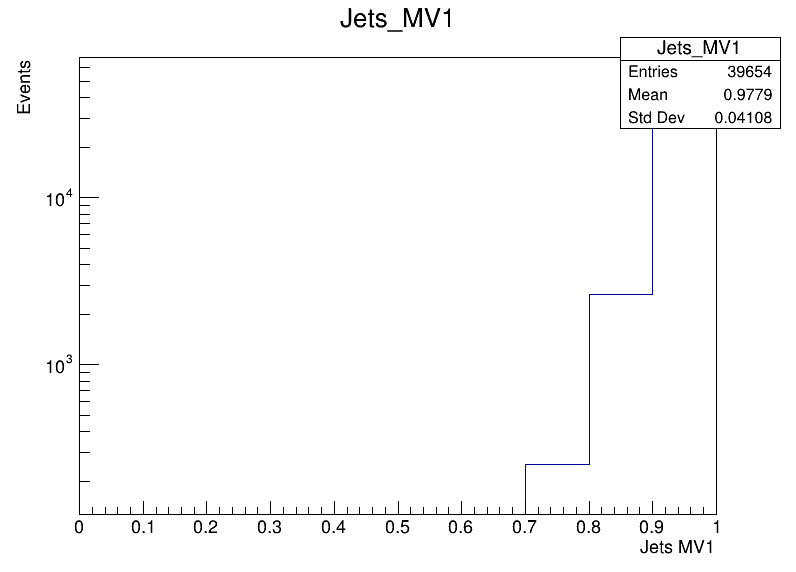

In [44]:
hist_jets_MV1->Draw();
canvas->SetLogy();
canvas->Draw();

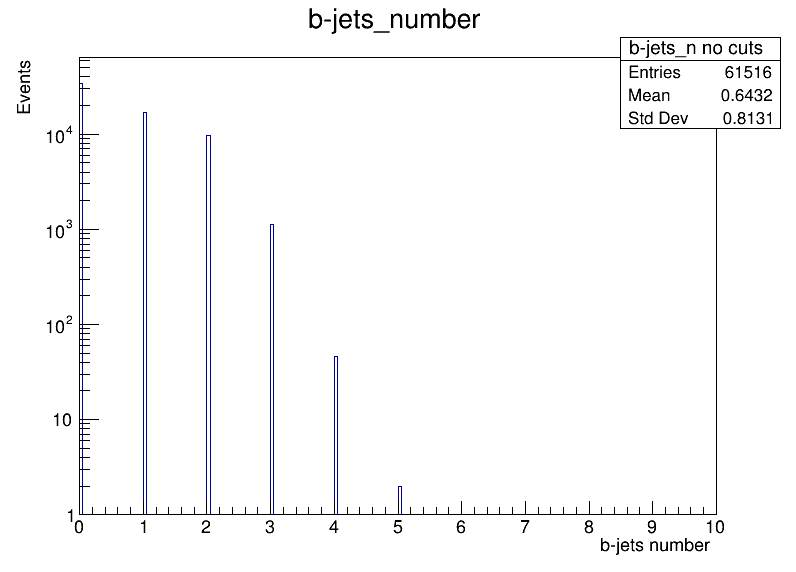

In [18]:
hist_bjets_n_b->Draw();
canvas->SetLogy();
canvas->Draw();

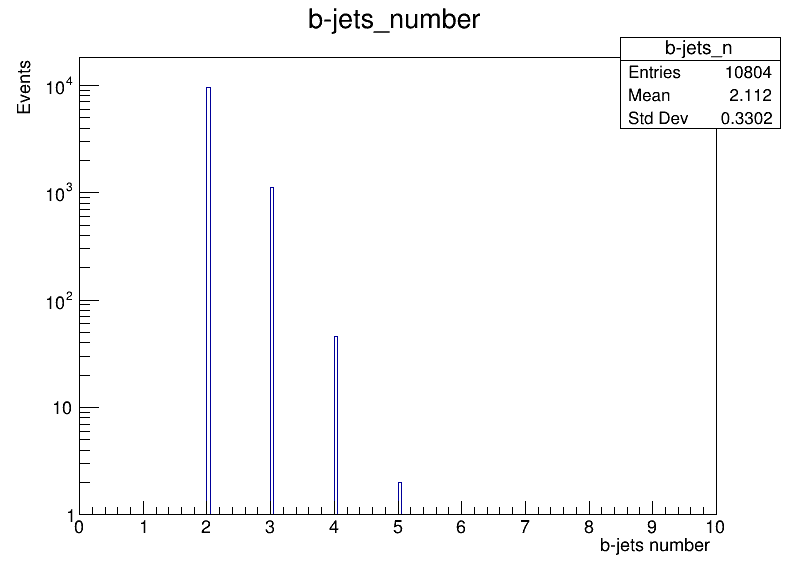

In [45]:
hist_bjets_n->Draw();
canvas->SetLogy();
canvas->Draw();

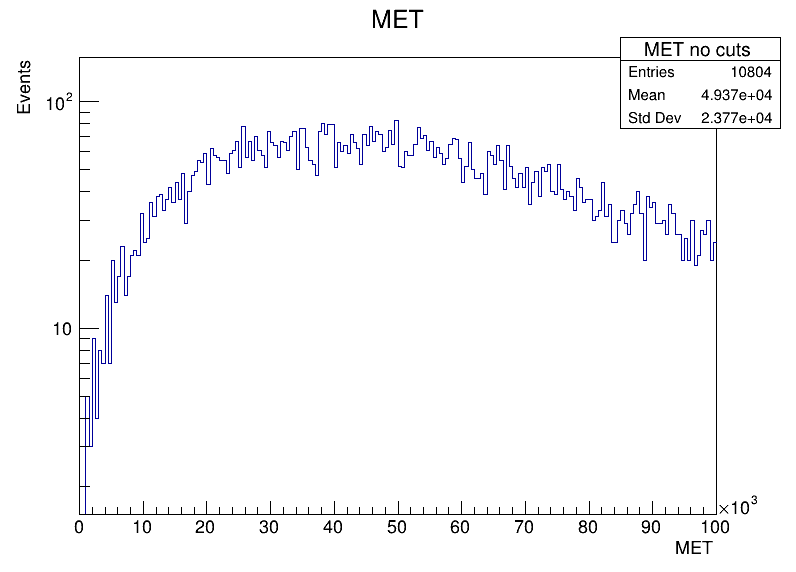

In [19]:
hist_MET_b->Draw();
canvas->SetLogy();
canvas->Draw();

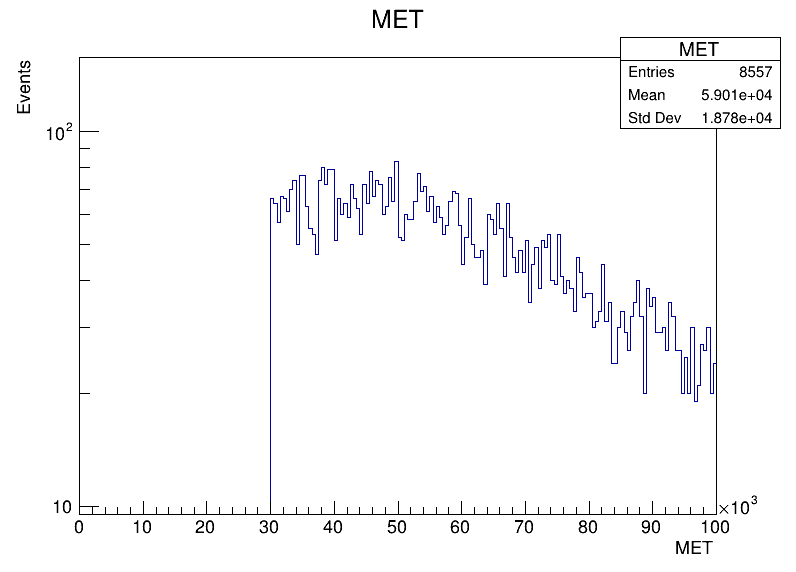

In [46]:
hist_MET->Draw();
canvas->SetLogy();
canvas->Draw();

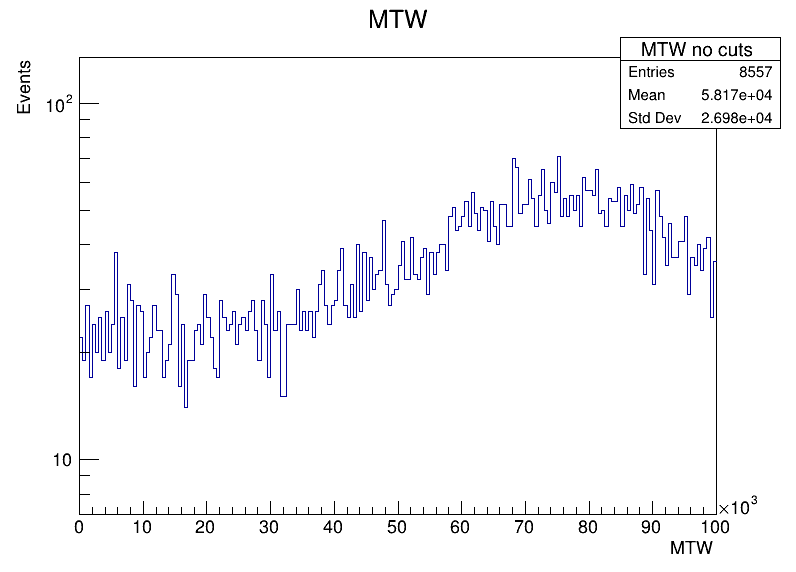

In [20]:
hist_MTW_b->Draw();
canvas->SetLogy();
canvas->Draw();

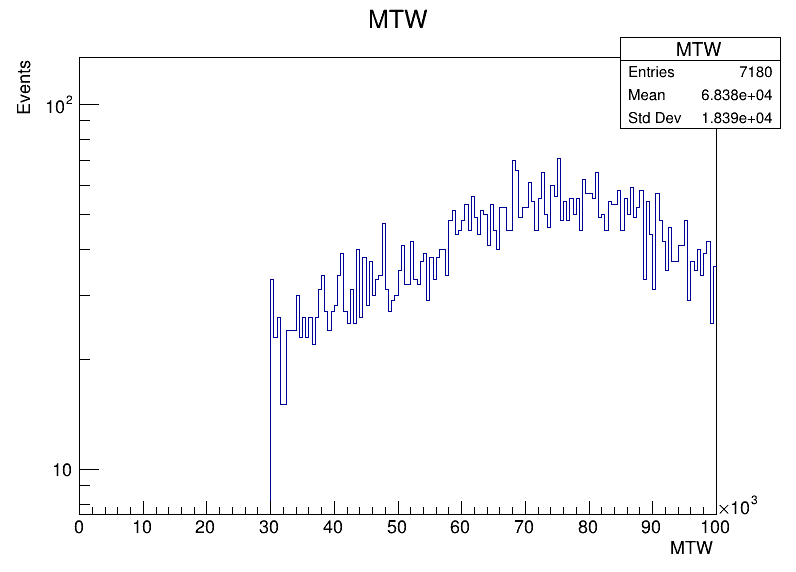

In [47]:
hist_MTW->Draw();
canvas->SetLogy();
canvas->Draw();